In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
X_word_tr, X_char_tr, y_tr, idx_word_tr, idx_tag_tr = wc_input_converter(merged_data, train_data)
X_word_val, X_char_val, y_val, idx_word_val, idx_tag_val = wc_input_converter(merged_data, val_data)
X_word_ts, X_char_ts, y_ts, idx_word_ts, idx_tag_ts = wc_input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [7]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10

In [8]:
model = wc_cnn_blstm_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 100, 10, 10)  5570       ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 dropout (Dropout)              (None, 100, 10, 10)  0           ['time_distributed[0][0]']       
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 100, 10, 10)  210        ['dropout[0][0]']            

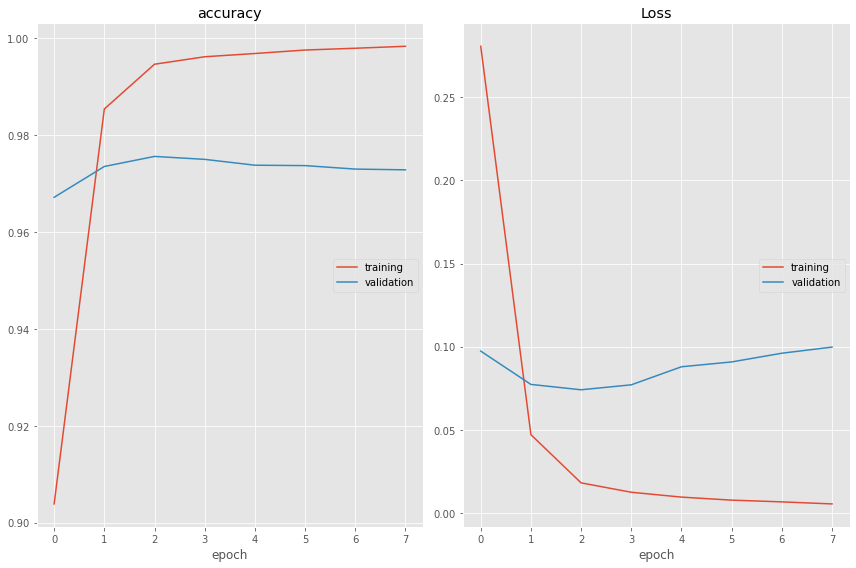

accuracy
	training         	 (min:    0.904, max:    0.998, cur:    0.998)
	validation       	 (min:    0.967, max:    0.976, cur:    0.973)
Loss
	training         	 (min:    0.005, max:    0.281, cur:    0.005)
	validation       	 (min:    0.074, max:    0.100, cur:    0.100)

Epoch 8: val_loss did not improve from 0.07403
91/91 [==============================] - 7s 77ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0997 - val_accuracy: 0.9728


In [9]:
root_path = 'model/'
model_name = 'wc_cnn_blstm_model.h5'
num_epoch = 50
batch_sz = 32
callbacks = get_callbacks(root_path, model_name)

history = model.fit(x=[X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    y=np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    #validation_data=(X_word_val, y_val),
                    validation_data=(
                      [X_word_val, np.array(X_char_val).reshape((len(X_char_val),
                                                                max_len, max_len_char))],
                        np.array(y_val).reshape(len(y_val), max_len, 1)
                    ),
                    batch_size=batch_sz,
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose=1
                    )

In [10]:
print(model.evaluate([X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))], np.array(y_ts).reshape(len(y_ts), max_len, 1)))

56/56 [==============================] - 1s 21ms/step - loss: 0.0972 - accuracy: 0.9737
[0.09716355800628662, 0.9737338423728943]


In [11]:
from keras.models import load_model

mdl = load_model('model/wc_cnn_blstm_model.h5')

In [12]:
predict_val = [X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))]

i = np.random.randint(0, X_word_ts.shape[0])
p = model.predict(predict_val)

p = np.argmax(p[i], axis=-1)
# print(p)
y_true = y_ts[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_ts[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))

Word                          True      	 Pred

------------------------------------------------------------
Maroko                        O         	O
.                             O         	O
Ndang                         JV        	JV
dilamar                       JV        	JV
,                             O         	O
ora                           JV        	JV
usah                          JV        	JV
Ngko                          JV        	ID
Ngko                          JV        	ID
.                             O         	O
.                             O         	O
.                             O         	O
.                             O         	O
Yang                          ID        	ID
butuh                         ID        	ID
kode                          ID        	ID
.                             O         	O
Boleh                         ID        	ID
dicopy                        MIX-ID-EN 	MIX-ID-EN
.                             O         	O


In [13]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_ts)):
    p = model.predict([X_word_ts,
                        np.array(X_char_ts).reshape((len(X_char_ts),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_ts[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_ts[i], y_true, p):
        if w != 0:
            print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))
            w_pair.append(idx_word_ts[w])
            true_pair.append(idx_tag_ts[true])
            pred_pair.append(idx_tag_ts[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	ID
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN   

In [14]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8850    0.9649    0.9232     22307
          JV     0.8084    0.8702    0.8381      4915
          EN     0.8900    0.8372    0.8628      5018
   MIX-ID-EN     0.9816    0.8243    0.8961       973
   MIX-ID-JV     0.9832    0.8357    0.9035       280
   MIX-JV-EN     0.9368    0.8556    0.8943       277
           O     0.9626    0.7850    0.8648     10154

   micro avg     0.8936    0.8935    0.8935     43924
   macro avg     0.9211    0.8533    0.8833     43924
weighted avg     0.8980    0.8935    0.8924     43924



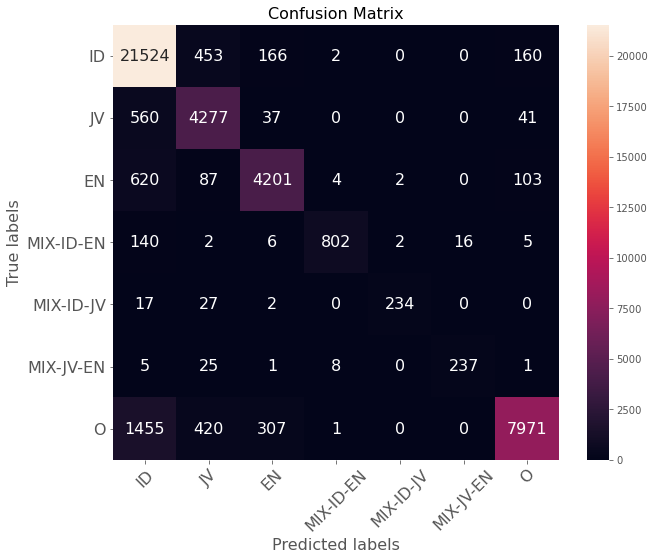

In [15]:
performance_report(true_flat, pred_flat)

In [16]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_flat, pred_flat)
print("Accuracy: ", round(acc, 4))

Accuracy:  0.8935


In [17]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [18]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [19]:
true_pred_file = 'tagging_result/wc_cnn_blstm_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

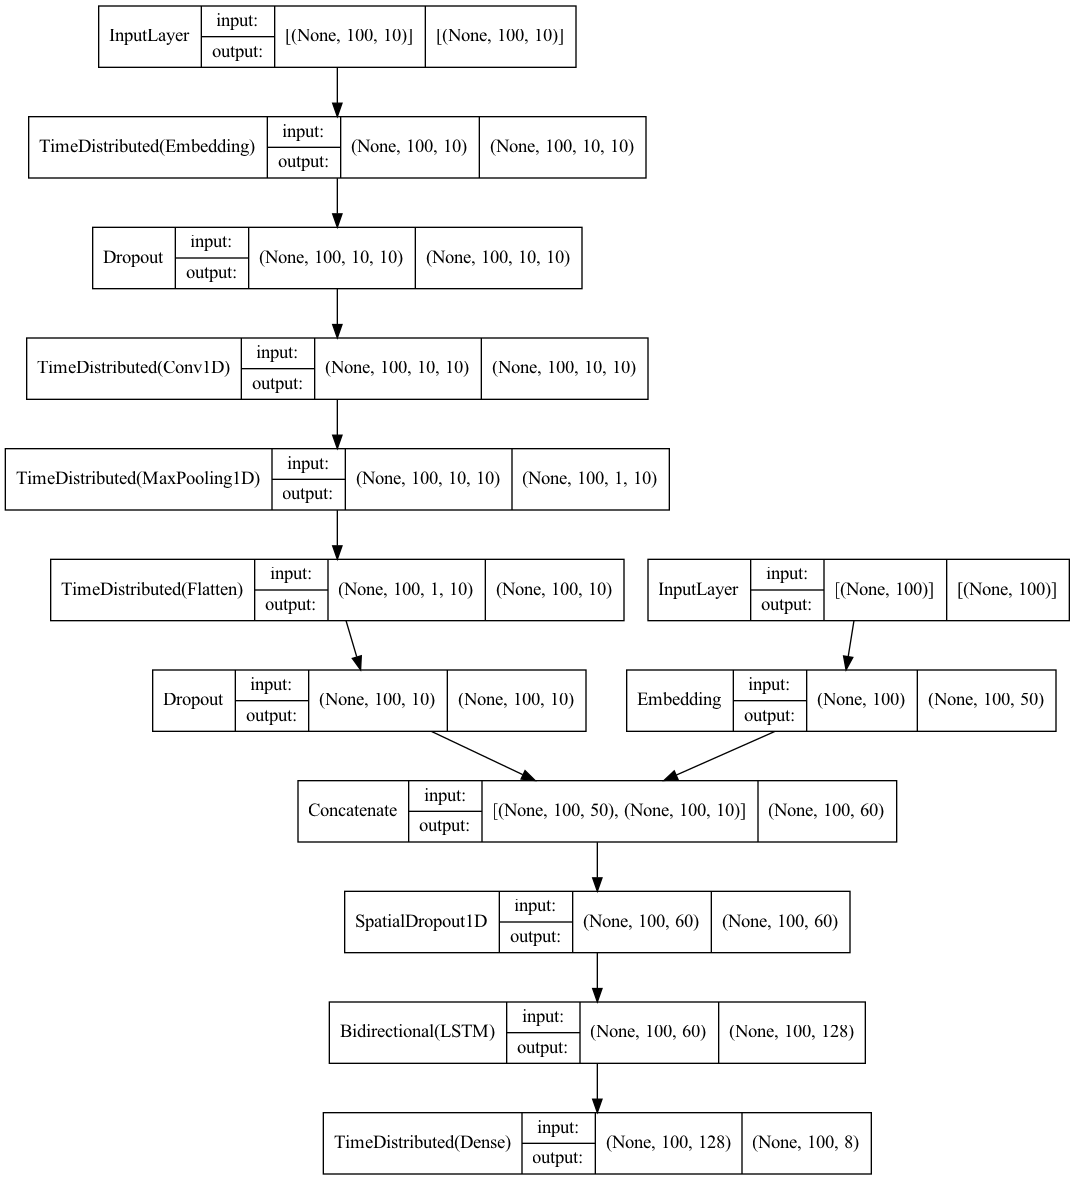

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_wc_cnn_blstm.png', show_shapes=True, show_layer_names=False)